# E-commerce Business Analytics Dashboard

## Executive Summary

This notebook provides comprehensive analysis of e-commerce business performance, focusing on revenue trends, customer behavior, and operational metrics. The analysis framework is designed to be configurable for any time period and reusable across different datasets.

## Table of Contents

1. [Introduction & Business Objectives](#introduction)
2. [Data Loading & Configuration](#data-loading)
3. [Data Preparation & Transformation](#data-preparation)
4. [Business Metrics Analysis](#business-metrics)
   - [Revenue Performance Analysis](#revenue-analysis)
   - [Product Category Performance](#category-analysis)
   - [Geographic Performance Analysis](#geographic-analysis)
   - [Customer Experience Analysis](#customer-experience)
5. [Summary of Key Insights](#summary)

## Data Dictionary

### Key Business Terms
- **Revenue**: Total monetary value from completed orders (price + freight)
- **AOV (Average Order Value)**: Average total value per order
- **Order Status**: Current state of order (delivered, canceled, shipped, processing, pending, returned)
- **Delivery Speed**: Time from order placement to customer delivery
- **Review Score**: Customer rating on 1-5 scale (5 being highest satisfaction)
- **NPS**: Net Promoter Score calculated from review scores

### Dataset Information
- **Orders**: Contains order-level information including timestamps and status
- **Order Items**: Contains item-level details including pricing and products
- **Products**: Contains product metadata including categories
- **Customers**: Contains customer geographic information
- **Reviews**: Contains customer feedback and ratings

## 1. Introduction & Business Objectives {#introduction}

### Business Questions This Analysis Addresses:

1. **Revenue Performance**: How is our revenue trending over time? What is our growth rate compared to previous periods?
2. **Product Strategy**: Which product categories are driving the most revenue? Where should we focus our efforts?
3. **Geographic Expansion**: Which states/regions present the biggest opportunities for growth?
4. **Customer Experience**: How satisfied are our customers? How does delivery speed impact satisfaction?
5. **Operational Efficiency**: What is our order fulfillment performance? Are we meeting delivery expectations?

### Analysis Configuration

The analysis is designed to be flexible and configurable. You can easily change the analysis period by modifying the variables below:

In [1]:
# Analysis Configuration
# Modify these variables to change the analysis period

CURRENT_YEAR = 2023
COMPARISON_YEAR = 2022
CURRENT_MONTH_START = 1  # January (set to None for full year)
CURRENT_MONTH_END = 12   # December (set to None for full year)

# Analysis parameters
TOP_N_CATEGORIES = 10
TOP_N_STATES = 15
ORDER_STATUS_FILTER = 'delivered'  # Focus on completed orders

print(f"Analysis Period: {CURRENT_YEAR} (Full Year)")
print(f"Comparison Period: {COMPARISON_YEAR} (Full Year)")
print(f"Order Status Filter: {ORDER_STATUS_FILTER}")

Analysis Period: 2023 (Full Year)
Comparison Period: 2022 (Full Year)
Order Status Filter: delivered


## 2. Data Loading & Configuration {#data-loading}

We use a custom data loader module that handles all data loading, cleaning, and initial processing. This ensures consistent data handling across different analyses.

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime
import warnings

# Import custom modules
from data_loader import EcommerceDataLoader, get_data_dictionary
from business_metrics import BusinessMetrics

# Configure display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
warnings.filterwarnings('ignore')

print("Libraries imported successfully")
print(f"Pandas version: {pd.__version__}")
print(f"Analysis date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Libraries imported successfully
Pandas version: 2.3.2
Analysis date: 2025-09-12 17:31:49


In [3]:
# Initialize data loader
data_loader = EcommerceDataLoader(data_path='ecommerce_data/')

# Load all datasets
print("Loading datasets...")
datasets = data_loader.load_all_datasets()

# Display dataset information
dataset_info = data_loader.get_dataset_info()
for name, info in dataset_info.items():
    print(f"\n{name.upper()} Dataset:")
    print(f"  Shape: {info['shape']}")
    print(f"  Memory usage: {info['memory_usage']}")
    print(f"  Columns: {', '.join(info['columns'][:5])}{'...' if len(info['columns']) > 5 else ''}")

Loading datasets...

ORDERS Dataset:
  Shape: (10000, 12)
  Memory usage: 3.06 MB
  Columns: order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at...

ORDER_ITEMS Dataset:
  Shape: (16047, 7)
  Memory usage: 4.06 MB
  Columns: order_id, order_item_id, product_id, seller_id, shipping_limit_date...

PRODUCTS Dataset:
  Shape: (6000, 9)
  Memory usage: 1.13 MB
  Columns: product_id, product_category_name, product_name_length, product_description_length, product_photos_qty...

CUSTOMERS Dataset:
  Shape: (8000, 5)
  Memory usage: 2.08 MB
  Columns: customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state

REVIEWS Dataset:
  Shape: (6571, 7)
  Memory usage: 2.32 MB
  Columns: review_id, order_id, review_score, review_comment_title, review_comment_message...


## 3. Data Preparation & Transformation {#data-preparation}

We create consolidated datasets optimized for business analysis. The data preparation includes:
- Merging relevant tables
- Adding calculated fields (delivery metrics, time dimensions)
- Filtering for specified date ranges
- Handling data quality issues

In [4]:
# Create complete sales dataset with all enrichment
print("Creating consolidated sales dataset...")
complete_sales_data = data_loader.create_complete_sales_dataset(status_filter=ORDER_STATUS_FILTER)

print(f"Complete sales dataset shape: {complete_sales_data.shape}")
print(f"Date range: {complete_sales_data['order_purchase_timestamp'].min()} to {complete_sales_data['order_purchase_timestamp'].max()}")
print(f"Total revenue in dataset: ${complete_sales_data['price'].sum():,.2f}")

# Display sample of the complete dataset
print("\nSample of complete sales dataset:")
complete_sales_data.head()

Creating consolidated sales dataset...
Complete sales dataset shape: (15095, 20)
Date range: 2021-12-31 16:55:08.451178 to 2024-01-01 04:12:51.260674
Total revenue in dataset: $6,806,626.83

Sample of complete sales dataset:


,order_id,order_item_id,product_id,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,year,month,quarter,day_of_week,total_revenue,product_category_name,customer_state,customer_city,review_score,delivery_days,delivery_category
0,ord_5fa044951857e02fd1347b47,1,prod_9b6f1793388ae983f852d189,111.91,9.50,cust_2d36e4b647be13c15df550af,delivered,2023-04-24 13:05:32.579655,2023-05-01 02:05:32.579655,2023,4,2,Monday,121.41,grocery_gourmet_food,TN,Knoxville,5.0,6,4-7 days
1,ord_5fa044951857e02fd1347b47,2,prod_c7b5997a4d0061a9f50e874c,878.42,77.50,cust_2d36e4b647be13c15df550af,delivered,2023-04-24 13:05:32.579655,2023-05-01 02:05:32.579655,2023,4,2,Monday,955.92,electronics,TN,Knoxville,5.0,6,4-7 days
2,ord_0a02a8a1d3d282380ed7d0cc,1,prod_d5f7b6e420ea5cffc504ab21,1030.31,15.47,cust_157f0ea0316c546ac08dae30,delivered,2022-05-15 07:51:22.471390,2022-05-23 01:51:22.471390,2022,5,2,Sunday,1045.78,home_garden,IL,Rockford,NaN,7,4-7 days
3,ord_0a02a8a1d3d282380ed7d0cc,2,prod_01b00f21c2758bf94f51234f,1299.50,232.29,cust_157f0ea0316c546ac08dae30,delivered,2022-05-15 07:51:22.471390,2022-05-23 01:51:22.471390,2022,5,2,Sunday,1531.79,home_garden,IL,Rockford,NaN,7,4-7 days
4,ord_8a243422e3ad7ab97a1fe175,1,prod_a904d724d4b2b8f571e66f19,1307.04,55.16,cust_bd21648bc4c95ae7aad6bda7,delivered,2022-04-18 15:02:44.122280,2022-04-30 16:02:44.122280,2022,4,2,Monday,1362.20,home_garden,MI,Detroit,3.0,12,8+ days


In [5]:
# Filter data for current analysis period
current_period_data = data_loader.filter_by_date_range(
    complete_sales_data, 
    start_year=CURRENT_YEAR, 
    end_year=CURRENT_YEAR,
    start_month=CURRENT_MONTH_START,
    end_month=CURRENT_MONTH_END
)

# Filter data for comparison period
comparison_period_data = data_loader.filter_by_date_range(
    complete_sales_data,
    start_year=COMPARISON_YEAR,
    end_year=COMPARISON_YEAR,
    start_month=CURRENT_MONTH_START,
    end_month=CURRENT_MONTH_END
)

print(f"Current period ({CURRENT_YEAR}) data shape: {current_period_data.shape}")
print(f"Comparison period ({COMPARISON_YEAR}) data shape: {comparison_period_data.shape}")
print(f"\nCurrent period revenue: ${current_period_data['price'].sum():,.2f}")
print(f"Comparison period revenue: ${comparison_period_data['price'].sum():,.2f}")

Current period (2023) data shape: (7448, 20)
Comparison period (2022) data shape: (7641, 20)

Current period revenue: $3,360,294.74
Comparison period revenue: $3,445,076.96


## 4. Business Metrics Analysis {#business-metrics}

This section contains comprehensive business analysis using our custom metrics calculation framework. All metrics are calculated using reusable functions that can be applied to any time period.

In [6]:
# Initialize business metrics calculator
metrics_calculator = BusinessMetrics(current_period_data)

print("Business metrics calculator initialized successfully")
print(f"Analysis ready for {len(current_period_data):,} transactions")

Business metrics calculator initialized successfully
Analysis ready for 7,448 transactions


### 4.1 Revenue Performance Analysis {#revenue-analysis}

This section analyzes overall revenue performance, growth trends, and key performance indicators.

In [7]:
# Calculate comprehensive revenue metrics
current_metrics = metrics_calculator.calculate_revenue_metrics(
    current_period_data, 
    comparison_period_data, 
    f"{CURRENT_YEAR} Full Year"
)

comparison_metrics = metrics_calculator.calculate_revenue_metrics(
    comparison_period_data, 
    period_label=f"{COMPARISON_YEAR} Full Year"
)

# Display executive summary
executive_summary = metrics_calculator.generate_executive_summary(current_metrics, comparison_metrics)
print(executive_summary)


EXECUTIVE SUMMARY - 2023 Full Year

Key Performance Indicators:
- Total Revenue: $3,360,294.74
- Total Orders: 4,635
- Average Order Value: $724.98
- Average Item Price: $451.17

Year-over-Year Performance:
- Revenue Growth: -2.46% 📉
- Order Growth: -2.40%
- AOV Growth: -0.06%



In [8]:
# Calculate and visualize monthly growth trends
monthly_trends = metrics_calculator.calculate_monthly_growth_trend(current_period_data, CURRENT_YEAR)

print(f"Monthly Revenue Trends for {CURRENT_YEAR}:")
print(monthly_trends[['month_name', 'price', 'revenue_growth']].round(2))

# Calculate average monthly growth
avg_monthly_growth = monthly_trends['revenue_growth'].mean()
print(f"\nAverage monthly growth rate: {avg_monthly_growth:.2f}%")

Monthly Revenue Trends for 2023:
   month_name      price  revenue_growth
0         Jan  284855.48             NaN
1         Feb  276758.54           -2.84
2         Mar  285618.77            3.20
3         Apr  253794.62          -11.14
4         May  301347.96           18.74
5         Jun  289126.72           -4.06
6         Jul  296209.39            2.45
7         Aug  286645.60           -3.23
8         Sep  303793.15            5.98
9         Oct  259890.15          -14.45
10        Nov  259518.93           -0.14
11        Dec  262735.43            1.24

Average monthly growth rate: -0.39%


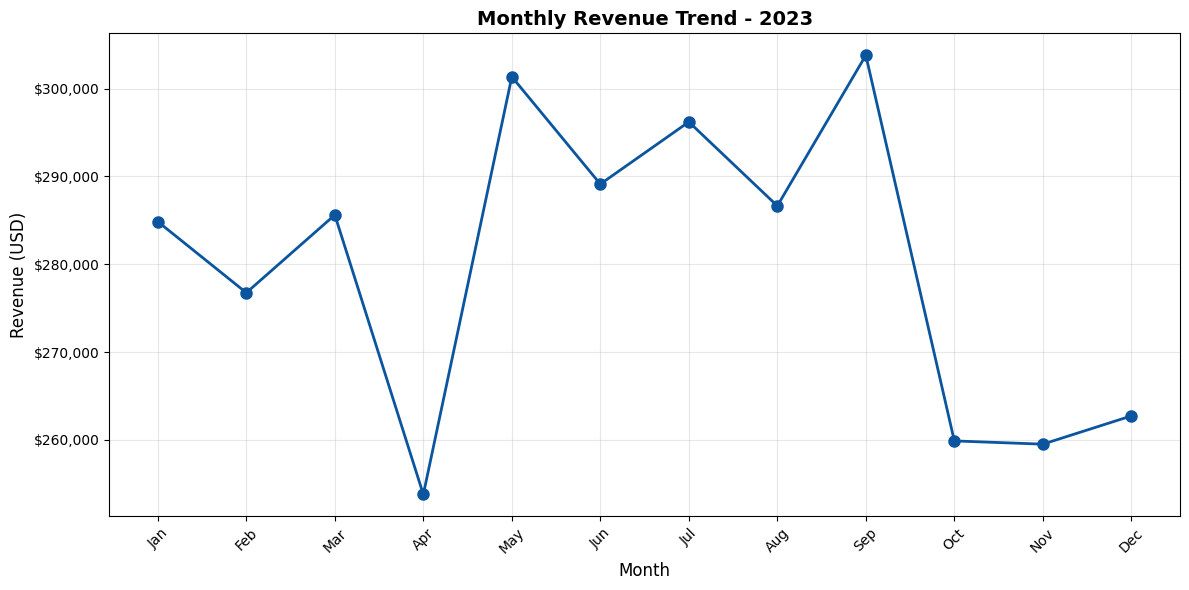


Insights:
Best performing month: Sep ($303,793.15)
Lowest performing month: Apr ($253,794.62)


In [9]:
# Create revenue trend visualization
revenue_trend_fig = metrics_calculator.create_revenue_trend_plot(
    monthly_trends, 
    f"Monthly Revenue Trend - {CURRENT_YEAR}"
)
plt.show()

# Additional insights
best_month = monthly_trends.loc[monthly_trends['price'].idxmax(), 'month_name']
worst_month = monthly_trends.loc[monthly_trends['price'].idxmin(), 'month_name']
print(f"\nInsights:")
print(f"Best performing month: {best_month} (${monthly_trends['price'].max():,.2f})")
print(f"Lowest performing month: {worst_month} (${monthly_trends['price'].min():,.2f})")

### 4.2 Product Category Performance {#category-analysis}

Analysis of product category performance to identify top-performing categories and growth opportunities.

In [10]:
# Analyze product category performance
category_performance = metrics_calculator.analyze_product_categories(
    current_period_data, 
    top_n=TOP_N_CATEGORIES
)

print(f"Top {TOP_N_CATEGORIES} Product Categories by Revenue ({CURRENT_YEAR}):")
print(category_performance)

Top 10 Product Categories by Revenue (2023):
                        total_revenue  avg_item_price  total_items  \
product_category_name                                                
electronics                1401359.21         1056.04         1327   
home_garden                 862653.27          750.79         1149   
sports_outdoors             278845.32          406.48          686   
automotive                  247707.10          506.56          489   
clothing_shoes_jewelry      232745.04          263.29          884   
toys_games                   70163.64          147.40          476   
health_personal_care         65370.27          103.76          630   
tools_home_improvement       54280.33          247.86          219   
beauty_personal_care         49213.30          156.23          315   
books_media                  38559.08           53.18          725   

                        total_orders  unique_customers  avg_order_value  \
product_category_name                  

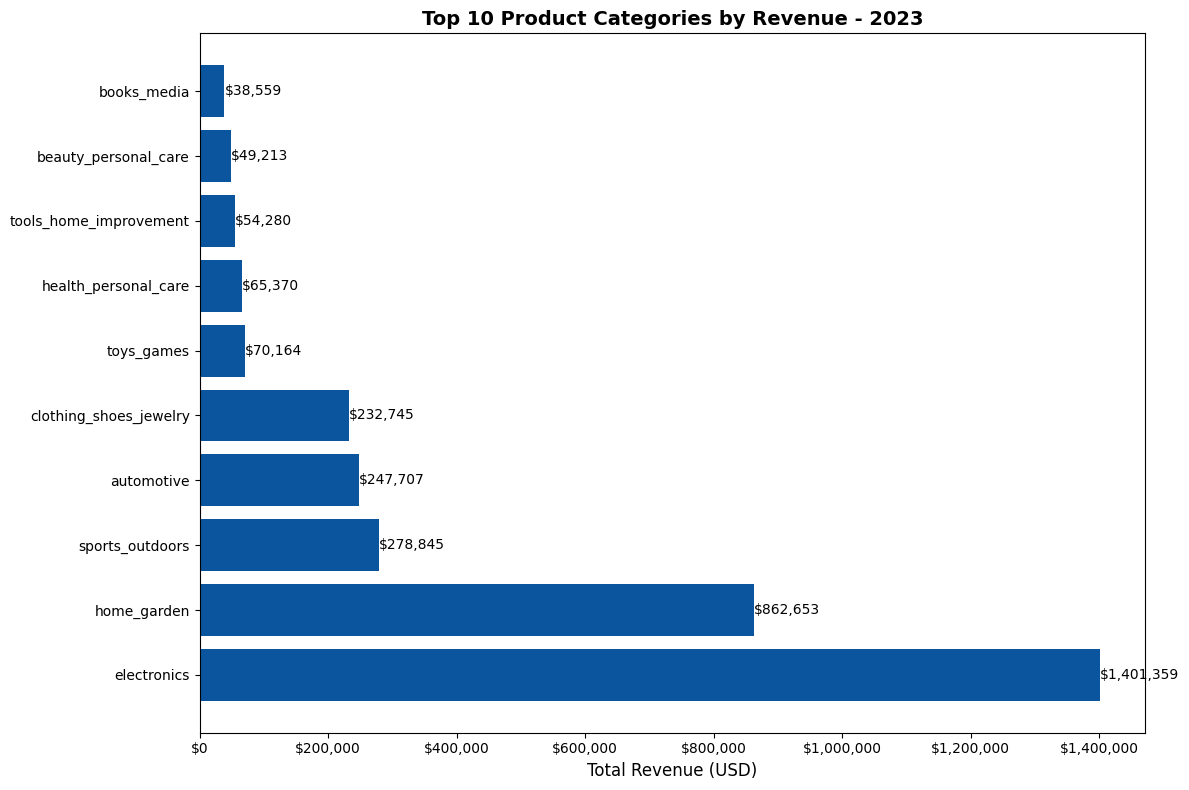


Category Insights:
Top category: electronics
Revenue: $1,401,359.21 (41.7% of total)
Number of categories analyzed: 10


In [11]:
# Create category performance visualization
category_plot = metrics_calculator.create_category_performance_plot(
    category_performance, 
    f"Top {TOP_N_CATEGORIES} Product Categories by Revenue - {CURRENT_YEAR}"
)
plt.show()

# Category insights
top_category = category_performance.index[0]
top_category_revenue = category_performance.iloc[0]['total_revenue']
top_category_share = category_performance.iloc[0]['revenue_share']

print(f"\nCategory Insights:")
print(f"Top category: {top_category}")
print(f"Revenue: ${top_category_revenue:,.2f} ({top_category_share:.1f}% of total)")
print(f"Number of categories analyzed: {len(category_performance)}")

### 4.3 Geographic Performance Analysis {#geographic-analysis}

Analysis of sales performance across different states to identify geographic opportunities and trends.

In [12]:
# Analyze geographic performance
geographic_performance = metrics_calculator.analyze_geographic_performance(
    current_period_data, 
    top_n=TOP_N_STATES
)

print(f"Top {TOP_N_STATES} States by Revenue ({CURRENT_YEAR}):")
print(geographic_performance)

Top 15 States by Revenue (2023):
                total_revenue  avg_item_price  total_orders  unique_customers  \
customer_state                                                                  
CA                  537880.74          438.73           769               582   
TX                  403303.49          464.10           561               438   
FL                  310195.84          438.75           431               332   
NY                  253111.85          400.49           384               286   
IL                  185930.89          460.22           260               190   
PA                  173260.68          493.62           225               172   
OH                  157619.72          464.95           200               151   
GA                  146414.65          478.48           190               145   
MI                  132325.60          405.91           210               164   
NC                  128314.74          444.00           177               13

In [13]:
# Create geographic heatmap
geo_heatmap = metrics_calculator.create_geographic_heatmap(
    geographic_performance, 
    f"Revenue by State - {CURRENT_YEAR}"
)
geo_heatmap.show()

# Geographic insights
top_state = geographic_performance.index[0]
top_state_revenue = geographic_performance.iloc[0]['total_revenue']
top_state_share = geographic_performance.iloc[0]['revenue_share']

print(f"\nGeographic Insights:")
print(f"Top performing state: {top_state}")
print(f"Revenue: ${top_state_revenue:,.2f} ({top_state_share:.1f}% of total)")
print(f"States contributing to top {TOP_N_STATES}: {', '.join(geographic_performance.index[:5])}")


Geographic Insights:
Top performing state: CA
Revenue: $537,880.74 (16.0% of total)
States contributing to top 15: CA, TX, FL, NY, IL


### 4.4 Customer Experience Analysis {#customer-experience}

Analysis of customer satisfaction metrics, delivery performance, and customer experience indicators.

In [14]:
# Analyze customer satisfaction
satisfaction_metrics = metrics_calculator.analyze_customer_satisfaction(current_period_data)

if 'error' not in satisfaction_metrics:
    print(f"Customer Satisfaction Analysis ({CURRENT_YEAR}):")
    print(f"Average Review Score: {satisfaction_metrics['avg_review_score']:.2f}/5.0")
    print(f"Total Reviews: {satisfaction_metrics['total_reviews']:,}")
    print(f"Customer Satisfaction Rate (4-5 stars): {satisfaction_metrics['satisfaction_rate']:.1f}%")
    print(f"Net Promoter Score: {satisfaction_metrics['nps_score']:.1f}")
    
    print("\nReview Score Distribution:")
    for score, percentage in satisfaction_metrics['review_distribution'].items():
        print(f"  {score} stars: {percentage:.1%}")
else:
    print(satisfaction_metrics['error'])

Customer Satisfaction Analysis (2023):
Average Review Score: 4.10/5.0
Total Reviews: 4,635
Customer Satisfaction Rate (4-5 stars): 51.6%
Net Promoter Score: 27.5

Review Score Distribution:
  1.0 stars: 3.5%
  2.0 stars: 6.9%
  3.0 stars: 15.4%
  4.0 stars: 24.3%
  5.0 stars: 49.9%


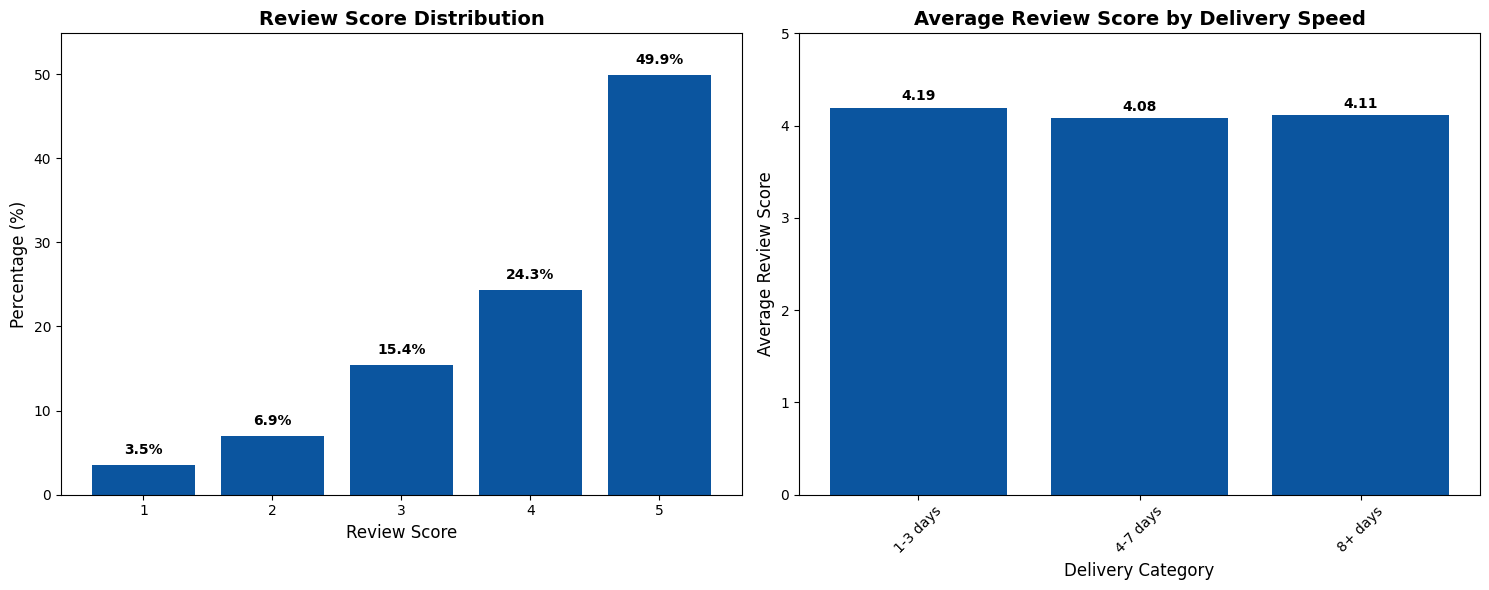

In [15]:
# Create customer satisfaction visualization
satisfaction_plot = metrics_calculator.create_satisfaction_plot(
    satisfaction_metrics, 
    f"Customer Satisfaction Analysis - {CURRENT_YEAR}"
)
plt.show()

In [16]:
# Analyze delivery performance
if 'delivery_days' in current_period_data.columns:
    delivery_stats = current_period_data['delivery_days'].describe()
    print(f"Delivery Performance Statistics ({CURRENT_YEAR}):")
    print(f"Average delivery time: {delivery_stats['mean']:.1f} days")
    print(f"Median delivery time: {delivery_stats['50%']:.1f} days")
    print(f"Fastest delivery: {delivery_stats['min']:.0f} days")
    print(f"Slowest delivery: {delivery_stats['max']:.0f} days")
    
    # Delivery category distribution
    if 'delivery_category' in current_period_data.columns:
        delivery_dist = current_period_data['delivery_category'].value_counts(normalize=True)
        print("\nDelivery Speed Distribution:")
        for category, percentage in delivery_dist.items():
            print(f"  {category}: {percentage:.1%}")
else:
    print("Delivery performance data not available")

Delivery Performance Statistics (2023):
Average delivery time: 8.0 days
Median delivery time: 8.0 days
Fastest delivery: 2 days
Slowest delivery: 15 days

Delivery Speed Distribution:
  8+ days: 55.1%
  4-7 days: 37.8%
  1-3 days: 7.1%


In [17]:
# Analyze order status distribution
order_status_dist = metrics_calculator.analyze_order_status_distribution(
    datasets['orders'][datasets['orders']['year'] == CURRENT_YEAR]
)

print(f"Order Status Distribution ({CURRENT_YEAR}):")
print(order_status_dist)

# Calculate operational metrics
delivered_rate = order_status_dist[order_status_dist['order_status'] == 'delivered']['percentage'].iloc[0]
canceled_rate = order_status_dist[order_status_dist['order_status'] == 'canceled']['percentage'].iloc[0]

print(f"\nOperational Insights:")
print(f"Order fulfillment rate: {delivered_rate:.1f}%")
print(f"Order cancellation rate: {canceled_rate:.1f}%")

Order Status Distribution (2023):
  order_status  percentage
0    delivered       93.64
1      shipped        3.19
2     canceled        1.29
3   processing        1.19
4      pending        0.51
5     returned        0.18

Operational Insights:
Order fulfillment rate: 93.6%
Order cancellation rate: 1.3%


## 5. Summary of Key Insights {#summary}

Based on the comprehensive analysis above, here are the key insights and recommendations:

In [18]:
# Generate comprehensive summary
print("=" * 80)
print(f"COMPREHENSIVE BUSINESS ANALYSIS SUMMARY - {CURRENT_YEAR}")
print("=" * 80)

# Revenue Summary
revenue_change = current_metrics['revenue_growth'] if 'revenue_growth' in current_metrics else 0
revenue_direction = "increased" if revenue_change > 0 else "decreased"

print(f"\n1. REVENUE PERFORMANCE:")
print(f"   - Total Revenue: ${current_metrics['total_revenue']:,.2f}")
print(f"   - Year-over-year change: {revenue_change:.2f}% ({revenue_direction})")
print(f"   - Average Order Value: ${current_metrics['average_order_value']:.2f}")
print(f"   - Total Orders: {current_metrics['total_orders']:,}")

# Category Performance
if len(category_performance) > 0:
    print(f"\n2. PRODUCT CATEGORY PERFORMANCE:")
    print(f"   - Top performing category: {category_performance.index[0]}")
    print(f"   - Top category revenue: ${category_performance.iloc[0]['total_revenue']:,.2f}")
    print(f"   - Market concentration: Top 3 categories account for {category_performance.head(3)['revenue_share'].sum():.1f}% of revenue")

# Geographic Performance
if len(geographic_performance) > 0:
    print(f"\n3. GEOGRAPHIC PERFORMANCE:")
    print(f"   - Top performing state: {geographic_performance.index[0]}")
    print(f"   - Top state revenue: ${geographic_performance.iloc[0]['total_revenue']:,.2f}")
    print(f"   - Geographic concentration: Top 5 states account for {geographic_performance.head(5)['revenue_share'].sum():.1f}% of revenue")

# Customer Experience
if 'error' not in satisfaction_metrics:
    print(f"\n4. CUSTOMER EXPERIENCE:")
    print(f"   - Average customer satisfaction: {satisfaction_metrics['avg_review_score']:.2f}/5.0")
    print(f"   - Customer satisfaction rate: {satisfaction_metrics['satisfaction_rate']:.1f}% (4-5 star reviews)")
    print(f"   - Net Promoter Score: {satisfaction_metrics['nps_score']:.1f}")
    if 'delivery_days' in current_period_data.columns:
        avg_delivery = current_period_data['delivery_days'].mean()
        print(f"   - Average delivery time: {avg_delivery:.1f} days")

# Operational Metrics
print(f"\n5. OPERATIONAL METRICS:")
print(f"   - Order fulfillment rate: {delivered_rate:.1f}%")
print(f"   - Order cancellation rate: {canceled_rate:.1f}%")
print(f"   - Monthly growth volatility: {monthly_trends['revenue_growth'].std():.2f}%")

print("\n" + "=" * 80)

COMPREHENSIVE BUSINESS ANALYSIS SUMMARY - 2023

1. REVENUE PERFORMANCE:
   - Total Revenue: $3,360,294.74
   - Year-over-year change: -2.46% (decreased)
   - Average Order Value: $724.98
   - Total Orders: 4,635

2. PRODUCT CATEGORY PERFORMANCE:
   - Top performing category: electronics
   - Top category revenue: $1,401,359.21
   - Market concentration: Top 3 categories account for 75.7% of revenue

3. GEOGRAPHIC PERFORMANCE:
   - Top performing state: CA
   - Top state revenue: $537,880.74
   - Geographic concentration: Top 5 states account for 50.3% of revenue

4. CUSTOMER EXPERIENCE:
   - Average customer satisfaction: 4.10/5.0
   - Customer satisfaction rate: 51.6% (4-5 star reviews)
   - Net Promoter Score: 27.5
   - Average delivery time: 8.0 days

5. OPERATIONAL METRICS:
   - Order fulfillment rate: 93.6%
   - Order cancellation rate: 1.3%
   - Monthly growth volatility: 8.78%



### Strategic Recommendations

Based on the analysis results, here are strategic recommendations for business improvement:

#### Revenue Growth Opportunities
- Focus on months showing positive growth trends
- Investigate factors contributing to revenue decline and develop mitigation strategies
- Optimize pricing strategies for better average order values

#### Product Portfolio Optimization
- Invest more resources in top-performing product categories
- Evaluate underperforming categories for improvement or discontinuation
- Consider cross-selling opportunities between high and low-performing categories

#### Geographic Expansion Strategy
- Strengthen market position in top-performing states
- Develop targeted marketing campaigns for underperforming regions
- Analyze logistics and delivery optimization opportunities by geography

#### Customer Experience Enhancement
- Maintain or improve delivery speed to sustain customer satisfaction
- Implement programs to address negative reviews and improve NPS
- Develop loyalty programs for high-value customers

#### Operational Excellence
- Reduce order cancellation rates through better inventory management
- Optimize fulfillment processes to maintain high delivery rates
- Implement predictive analytics for demand forecasting

---

**Note**: This analysis framework can be easily adapted for different time periods, product segments, or geographic regions by modifying the configuration parameters at the beginning of the notebook.

In [19]:
# Optional: Export key metrics to CSV for further analysis
export_filename = f"business_metrics_{CURRENT_YEAR}_analysis.csv"

try:
    metrics_calculator.export_metrics_to_csv(current_metrics, export_filename)
    print(f"Metrics exported successfully to {export_filename}")
except Exception as e:
    print(f"Export failed: {e}")
    
print(f"\nAnalysis completed for {CURRENT_YEAR} vs {COMPARISON_YEAR}")
print(f"Total execution time: {datetime.now()}")

Metrics exported to business_metrics_2023_analysis.csv
Metrics exported successfully to business_metrics_2023_analysis.csv

Analysis completed for 2023 vs 2022
Total execution time: 2025-09-12 17:31:53.087920
